# Particle Implementation of Minimizing OT Map
In this notebook, we compute the optimal transport map between two Gaussian distributions to compare with the kernel method proposed in Liu et al, 2021.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import xlogy
from scipy.signal import convolve
from copy import deepcopy

In [5]:
N       = 20000 # number of particles for computing the marginal
M       = 40000 # number of points sampled from the target marginals
dmu     = 2 # dimension of the first target distribution, mu
dnu     = 2 # dimension of the second target distribution, nu

Nx      = 19 # spacing for histogram boxes for gradient computations
Nx_plot = 25 # spacing for histogram boxes for plotting

In [ ]:
def sample_mu(K, dmu,option=0):
    '''sample from the distribution mu'''
    if dmu == 1:
        out = np.random.normal(0.5, 0.2, K)
        
    else:
        if option==0:
            means = 0.4*np.ones(dmu) #np.random.uniform(0.25,0.75,dmu)
            cov   = 0.02* np.eye(dmu) #*np.random.uniform(0.01,0.02)
            out = np.random.multivariate_normal(means, cov, K)
        else:
            #sample a circle
            out   = np.ones((K,dmu))*0.5
            angle = np.random.uniform(0,2*np.pi,int(4*K/5))
            radius = np.random.uniform(0.4,0.55,int(4*K/5))
            out[:int(4*K/5),0] = out[:int(4*K/5),0] + radius*np.cos(angle)
            out[:int(4*K/5),1] = out[:int(4*K/5),1] + radius*np.sin(angle)
            out[int(4*K/5):,:] = np.random.normal(0.5, 0.1, (int(K/5),dmu))

    out[out<0] = np.random.uniform(0,1,np.sum(out<0))
    out[out>1] = np.random.uniform(0,1,np.sum(out>1))

    return out


def sample_nu(K, dnu,option=0):
    '''sample from the distribution nu'''
    if dnu == 1:
        out = np.concatenate([np.random.normal(0.3, 0.1, int(K/4)), np.random.normal(0.7, 0.1, int(K/4)), np.random.uniform(0,1,int(K/2))])

    else:
        if option==0:
            means1 = 0.6*np.ones(dnu)  #np.random.uniform(0.0,0.99,dnu)
            cov1   = np.eye(dnu)*0.02 #np.random.uniform(0.01,0.03)
            out    = np.random.multivariate_normal(means1, cov1, K)

        else:
            out = np.ones((K,dnu))*0.5
            out[:int(1*K/2),0]           += np.random.normal(0.25,0.1,int(K/2))*np.random.choice([-1,1],int(K/2),p=[0.5,0.5])
            out[:int(1*K/2),1]           += np.random.normal(0.0,0.1,int(K/2))*np.random.choice([-1,1],int(K/2))
            out[int(K/2):,1]             += np.random.normal(0.25,0.1,int(K/2))*np.random.choice([-1,1],int(K/2),p=[0.5,0.5])
            out[int(K/2):,0]             += np.random.normal(0.0,0.1,int(K/2))*np.random.choice([-1,1],int(K/2))



    out[out<0] = np.random.uniform(0,1,np.sum(out<0))
    out[out>1] = np.random.uniform(0,1,np.sum(out>1))
    return out

def entropy_rho_first(x_hist,y_hist,mu_hist,nu_hist,eps=1e-6):
    mu_hist[mu_hist==0] = eps
    nu_hist[nu_hist==0] = eps
    entropy_1     = dmu*np.sum(xlogy(x_hist,x_hist/mu_hist))
    entropy_2     = dnu*np.sum(xlogy(y_hist,y_hist/nu_hist))
    return entropy_1 + entropy_2


def entropy_mu_first(x_hist,y_hist,mu_hist,nu_hist,eps=1e-6):
    x_hist[x_hist==0] = eps
    y_hist[y_hist==0] = eps
    entropy_1     = dmu*np.sum(xlogy(mu_hist,mu_hist/x_hist))
    entropy_2     = dnu*np.sum(xlogy(nu_hist,nu_hist/y_hist))
    return entropy_1 + entropy_2


def energy(X,Y,x_hist,y_hist,mu_hist,nu_hist,Lambda,dx,eps=1e-6,entropy="rho first"):
    '''compute the energy of the configuration X,Y'''
    
    coupling_cost = np.sum((X-Y)**2)/N
    if entropy=="rho first":
        ent_total = entropy_rho_first(x_hist,y_hist,mu_hist,nu_hist,eps)*dx

    elif entropy=="mu first":
        ent_total = entropy_mu_first(x_hist,y_hist,mu_hist,nu_hist,eps)*dx

    elif entropy=="alternating":
        ent_total = 0.5*(entropy_rho_first(x_hist,y_hist,mu_hist,nu_hist,eps)*dx 
                         + entropy_mu_first(x_hist,y_hist,mu_hist,nu_hist,eps)*dx)
    else:
        raise ValueError("Entropy type not recognized")
    return coupling_cost + Lambda*ent_total,ent_total,coupling_cost


def project_onto_square(X):
    '''project onto the square [0,1]^d'''
    X[X<0] = 0
    X[X>1] = 0.99
    return X


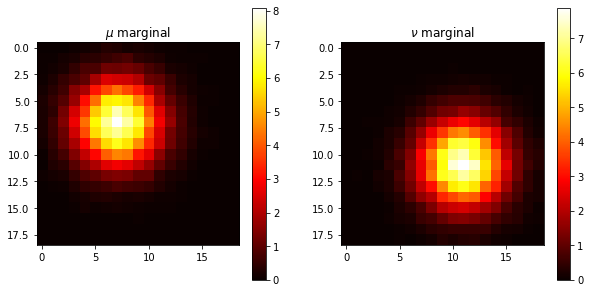

In [7]:
opt = 0
mu_samples = sample_mu(M, dmu,option=opt)
mu_marginal = np.histogramdd(mu_samples, bins=[np.linspace(0, 1, Nx+1)]*dmu,density=True)[0]
nu_samples = sample_nu(M, dnu,option=opt)
nu_marginal = np.histogramdd(nu_samples, bins=[np.linspace(0, 1, Nx+1)]*dnu,density=True)[0]

# plot results
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(mu_marginal, cmap='hot', interpolation='nearest')
plt.title(r'$\mu$ marginal')
plt.colorbar()
plt.subplot(122)
plt.imshow(nu_marginal, cmap='hot', interpolation='nearest')
plt.title(r'$\nu$ marginal')
plt.colorbar()
plt.show()



We implement first-order left, right differences and central differences, and central second order differences.

In [8]:
def left_derivative(x, Nx, dim):
    '''Left first-order derivative for 2d system.'''
    grad_first = np.zeros([Nx]*dim)
    grad_second = np.zeros([Nx]*dim)
    grad_1 = np.diff(x,axis=0)
    grad_2 = np.diff(x,axis=1)
    grad_first[1:,:] = grad_1
    grad_second[:,1:] = grad_2
    grad_first[0,:] = x[1,:]-x[0,:]     # deal with the boundaries
    grad_first[-1,:] = x[-1,:]-x[-2,:]  # deal with the boundaries
    grad_second[:,0] = x[:,1]-x[:,0]    # deal with the boundaries
    grad_second[:,-1] = x[:,-1]-x[:,-2] # deal with the boundaries

    return grad_first, grad_second


def right_derivative(x, Nx, dim):
    '''Right first-order derivative for 2d system.'''
    grad_first = np.zeros([Nx]*dim)
    grad_second = np.zeros([Nx]*dim)
    grad_1 = np.diff(x,axis=0)
    grad_2 = np.diff(x,axis=1)
    grad_first[:-1,:] = grad_1
    grad_second[:,:-1] = grad_2
    grad_first[-1,:] = x[-1,:]-x[-2,:]  # deal with the boundaries
    grad_first[0,:] = x[1,:]-x[0,:]     # deal with the boundaries
    grad_second[:,-1] = x[:,-1]-x[:,-2] # deal with the boundaries
    grad_second[:,0] = x[:,1]-x[:,0]    # deal with the boundaries

    return grad_first, grad_second


def central_first_order(x, Nx, dim):
    '''Central first-order derivative for 2d system.'''
    grad_first            = np.zeros([Nx]*dim)
    grad_second           = np.zeros([Nx]*dim)
    grad_1                = 0.5*np.diff(x[::2,:],axis=0)
    grad_2                = 0.5*np.diff(x[1::2,:],axis=0)
    grad_first[1::2,:]    = grad_1
    grad_first[2:-1:2,:]  = grad_2
    grad_first[0,:]       = x[1,:]-x[0,:]                  # deal with the boundaries
    grad_first[-1,:]      = x[-1,:]-x[-2,:]                # deal with the boundaries
    grad_1                = 0.5*np.diff(x[:,::2],axis=1)
    grad_2                = 0.5*np.diff(x[:,1::2],axis=1)
    grad_second[:,1::2]   = grad_1
    grad_second[:,2:-1:2] = grad_2
    grad_second[:,0]      = x[:,1]-x[:,0]                  # deal with the boundaries
    grad_second[:,-1]     = x[:,-1]-x[:,-2]                # deal with the boundaries

    return grad_first, grad_second


def central_second_order(x, Nx, dim):
    '''Central second-order derivative for 2d system.'''
    grad_first  = np.zeros([Nx]*dim)
    grad_second = np.zeros([Nx]*dim)

    diff_kernel = -np.array([[1/12,-2/3,0,2/3,-1/12]])
    grad_1      = convolve(x,diff_kernel.T,mode='same')
    grad_2      = convolve(x,diff_kernel,mode='same')
    grad_first  = grad_1
    grad_second = grad_2

    # deal with the boundaries
    grad_first[0,:]     = x[1,:]-x[0,:]
    grad_first[-1,:]    = x[-1,:]-x[-2,:]
    grad_second[:,0]    = x[:,1]-x[:,0]
    grad_second[:,-1]   = x[:,-1]-x[:,-2]
    grad_first[1,:]     = 0.5*(x[2,:]-x[0,:])
    grad_first[-2,:]    = 0.5*(x[-1,:]-x[-3,:])
    grad_second[:,1]    = 0.5*(x[:,2]-x[:,0])
    grad_second[:,-2]   = 0.5*(x[:,-1]-x[:,-3])

    return grad_first, grad_second

In [9]:
def split_marginal(marginal,dim,ord=2):
    '''split the marginal into smaller boxes'''
    marginal_split = np.sum(np.reshape(marginal,[Nx,int(Nx/ord),ord],order="C"),axis=-1)
    marginal_split = np.sum(np.reshape(marginal_split.T,[int(Nx/ord)]*dim+[ord],order="C"),axis=-1).T
    marginal_split = np.repeat(marginal_split,ord,axis=0)/ord
    marginal_split = np.repeat(marginal_split,ord,axis=1)/ord
    return marginal_split

def approx_grad(map_marginal,target_marginal,dim,eps=1e-10,rho_first=True,order=1):
    '''compute the gradient of the KL divergence between the map and the target marginals
    
    If rho_first is True, the gradient is computed for the KL divergence (rho_1||mu) where rho is the map marginal and mu the target marginal
    Otherwise, the gradient is computed for the KL divergence (mu||rho_1) where mu is the target marginal and rho the map marginal
    
    order=0 randomly selects a left or right first order derivative
    order=1 computes the central first order derivative
    order=2 computes the central second order derivative  '''    
    
    if not rho_first:
        map_marginal[map_marginal==0] = eps
        ratio = target_marginal/map_marginal
    else:
        target_marginal[target_marginal==0] = eps
        ratio = -np.log(map_marginal/target_marginal)
        ratio[map_marginal==0] = 0
    if order == 0:
        # randomly chose right or left derivative
        if np.random.uniform(0,1)>0.5:
            grad_first,grad_second = left_derivative(ratio,Nx,dim)
        else:
            grad_first,grad_second = right_derivative(ratio,Nx,dim)

    if order == 1:
        grad_first,grad_second = central_first_order(ratio,Nx,dim)
    
    if order == 2:
        grad_first,grad_second = central_second_order(ratio,Nx,dim)

    return grad_first,grad_second

In [ ]:

def run_gradient_descent(X0,Y0,Lambda_initial,T,dt,entropy="rho first",switch_every=10,order=0,noise=None):
    '''
    entropy options:
    "rho first": KL(rho_1||mu) and KL(rho_2||nu)
    "mu first": KL(mu||rho_1) and KL(nu||rho_2
    "alterating": switches between KL(rho_1||mu)+KL(rho_2||nu) and KL(mu||rho_1)+KL(nu||rho_2)

    If "alternating" is selected, use keyword argument switch_every to set the number of iterations between switches.

    order=0 randomly selects a left or right first order derivative with equal probability
    order=1 computes the central first order derivative
    order=2 computes the central second order derivative 
    '''


    energy_history = np.zeros(T)
    coupling_cost  = np.zeros(T)
    lambda_history = np.zeros(T)
    Lambda,X,Y     = deepcopy(Lambda_initial),deepcopy(X0),deepcopy(Y0)
    halfN          = int(N/2)
    if noise is None:
        noiseX = np.zeros((T,halfN,dmu))
        noiseY = np.zeros((T,halfN,dnu))
    else:
        noiseX,noiseY = noise


    for tt in tqdm(range(T)):
        # compute marginals
        x_marginal = np.histogramdd(X, bins=[np.linspace(0, 1, Nx+1)]*dmu,density=True)[0]
        y_marginal = np.histogramdd(Y, bins=[np.linspace(0, 1, Nx+1)]*dnu,density=True)[0]

        # compute energy
        energy_history[tt],KL_terms,coupling_cost[tt] = energy(X,Y,x_marginal,y_marginal,mu_marginal,nu_marginal,Lambda,0.5/N,entropy=entropy)
        
        # if KL terms is not infinite, increase Lambda
        if KL_terms < 1e10:
                Lambda += 500*dt*KL_terms
        lambda_history[tt] = Lambda

        # approximate gradient of KL divergences
        if entropy == "rho first":
            grad_x_marginal1,grad_x_marginal2 = approx_grad(x_marginal, mu_marginal, dmu, eps=0.5/N, rho_first=True,order=order)
            grad_y_marginal1,grad_y_marginal2 = approx_grad(y_marginal, nu_marginal, dnu, eps=0.5/N, rho_first=True,order=order)
        elif entropy == "mu first":
            grad_x_marginal1,grad_x_marginal2 = approx_grad(x_marginal, mu_marginal, dmu, eps=0.5/N, rho_first=False,order=order)
            grad_y_marginal1,grad_y_marginal2 = approx_grad(y_marginal, nu_marginal, dnu, eps=0.5/N, rho_first=False,order=order)
        elif entropy == "alternating":
                grad_y_marginal1,grad_y_marginal2 = approx_grad(y_marginal, nu_marginal, dnu, eps=0.5/N, rho_first=True,order=order[0])
                grad_x_marginal1,grad_x_marginal2 = approx_grad(x_marginal, mu_marginal, dmu, eps=0.5/N, rho_first=False,order=order[1])

        else:
            raise ValueError("entropy must be 'rho first', 'mu first' or 'alternating'")

        # update particles
        indices_1 = np.floor(X[:, 0] * Nx).astype(int)
        indices_2 = np.floor(X[:, 1] * Nx).astype(int)
        grad_x1   = grad_x_marginal1[indices_1, indices_2]
        grad_x2   = grad_x_marginal2[indices_1, indices_2]
        indices_1 = np.floor(Y[:, 0] * Nx).astype(int)
        indices_2 = np.floor(Y[:, 1] * Nx).astype(int)
        grad_y1   = grad_y_marginal1[indices_1, indices_2]
        grad_y2   = grad_y_marginal2[indices_1, indices_2]


        X[halfN:,:] -= dt*( (X-Y)/Lambda - np.concatenate([grad_x1[:,np.newaxis],grad_x2[:,np.newaxis]],axis=1) )[halfN:,:] + noiseX[tt]
        Y[:halfN,:] -= dt*( (Y-X)/Lambda - np.concatenate([grad_y1[:,np.newaxis],grad_y2[:,np.newaxis]],axis=1) )[:halfN,:] + noiseY[tt]

        # if X or Y are outside of [0,1], project them back by amount they are outside
        X = project_onto_square(X)
        Y = project_onto_square(Y)

    # save results
    np.savez("results/gd_kernel_{}_{}_{}_{}_{}.npz".format(Lambda_initial,T,dt,entropy.replace(" ",""),order),X=X,Y=Y,energy_history=energy_history,lambda_history=lambda_history,coupling_cost=coupling_cost)
    return X,Y,energy_history,lambda_history,coupling_cost


In [ ]:
T = 2000
dt = 0.005
Lambda = 50 # weight for the KL divergence, initial condition



# correlated, half sampled from each
X1 = sample_mu(int(N/2),dmu,option=opt)
Y2 = sample_nu(int(N/2),dnu,option=opt)
X2 = Y2 + 0.005*np.random.uniform(-1,1,(int(N/2),dnu))
X2[X2<0] = Y2[X2<0]
X2[X2>1] = Y2[X2>1]
Y1 = X1 + 0.005*np.random.uniform(-1,1,(int(N/2),dmu))
Y1[Y1<0] = X1[Y1<0]
Y1[Y1>1] = X1[Y1>1]
Y  = np.concatenate([Y1,Y2],axis=0)
X  = np.concatenate([X1,X2],axis=0)

# noise 
noiseX              = np.zeros((T,int(N/2),dmu))
noiseY              = np.zeros((T,int(N/2),dnu))
noiseX[:100,:,:]    = np.sqrt(dt)*0.020*np.random.normal(0,1,(100,int(N/2),dmu))
noiseY[:100,:,:]    = np.sqrt(dt)*0.020*np.random.normal(0,1,(100,int(N/2),dnu))
noiseX[100:200,:,:] = np.sqrt(dt)*0.020*np.random.normal(0,1,(100,int(N/2),dmu))
noiseY[100:200,:,:] = np.sqrt(dt)*0.020*np.random.normal(0,1,(100,int(N/2),dnu))
noiseX[200:,:,:]    = np.sqrt(dt)*0.020*np.random.normal(0,1,(T-200,int(N/2),dmu))
noiseY[200:,:,:]    = np.sqrt(dt)*0.020*np.random.normal(0,1,(T-200,int(N/2),dnu))


# idea: don't move X1 or Y2, only move X2 and Y1
halfN = int(N/2)
X0 = deepcopy(X)
Y0 = deepcopy(Y)
X0_marginal = np.histogramdd(X0, bins=[np.linspace(0, 1, Nx+1)]*dmu,density=True)[0]
Y0_marginal = np.histogramdd(Y0, bins=[np.linspace(0, 1, Nx+1)]*dnu,density=True)[0]

# run gradient descent on the standar KL divergence option
rho_first_results      = run_gradient_descent(X0,Y0,Lambda,T,dt,entropy="rho first",order=0 ,noise=(noiseX,noiseY))


    

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\laure\AppData\Local\Temp/ipykernel_26120/1385713645.py:24: RuntimeWarning: divide by zero encountered in log
  ratio = -np.log(map_marginal/target_marginal)
100%|██████████| 2000/2000 [00:06<00:00, 288.18it/s]


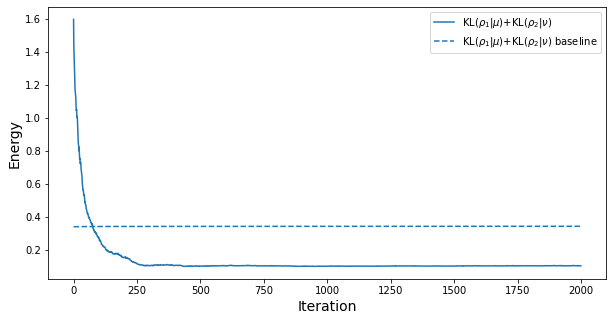

In [ ]:
# compare with randomly coupled joint distribution
baselineX = sample_mu(M,dmu,option=opt)
baselineY = sample_nu(M,dnu,option=opt)
baseline_x_marginal = np.histogramdd(baselineX, bins=[np.linspace(0, 1, Nx+1)]*dmu,density=True)[0]
baseline_y_marginal = np.histogramdd(baselineY, bins=[np.linspace(0, 1, Nx+1)]*dnu,density=True)[0]
energy_baseline_rhofirst = energy(baselineX,baselineY,baseline_x_marginal,baseline_y_marginal,mu_marginal,nu_marginal,Lambda,0.5/N)


# plot energies
plt.figure(figsize=(10,5))
plt.plot(rho_first_results[2],label=r'KL$(\rho_1|\mu)$+KL$(\rho_2|\nu)$')
plt.plot(np.ones(T)*(energy_baseline_rhofirst[2]+rho_first_results[3]*energy_baseline_rhofirst[1]),"--",color="tab:blue",label=r'KL$(\rho_1|\mu)$+KL$(\rho_2|\nu)$ baseline')
plt.legend()
plt.ylabel('Energy', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
# plt.ylim([0,50])
plt.show()



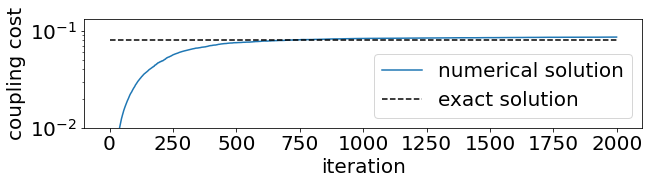

coupling cost 0.08637738034220528


In [ ]:
# plot coupling cost
plt.figure(figsize=(10,2))
plt.semilogy(rho_first_results[4],label=r'numerical solution')
plt.semilogy([0,T],[0.08,0.08],'k--',label='exact solution')
plt.legend(fontsize=20)
plt.ylabel('coupling cost', fontsize=20)
plt.xlabel('iteration', fontsize=20)
# set tick font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([1e-2,plt.ylim()[1]])
plt.savefig("coupling_cost.png",bbox_inches='tight')
plt.show()

print("coupling cost",rho_first_results[4][-1])

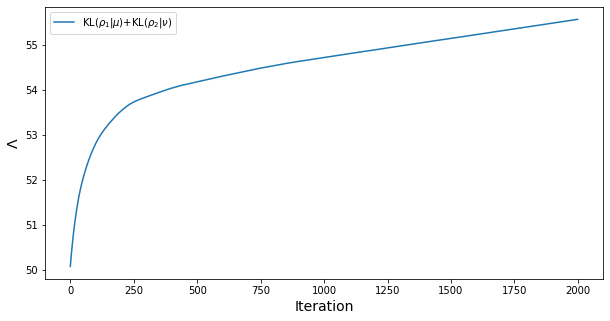

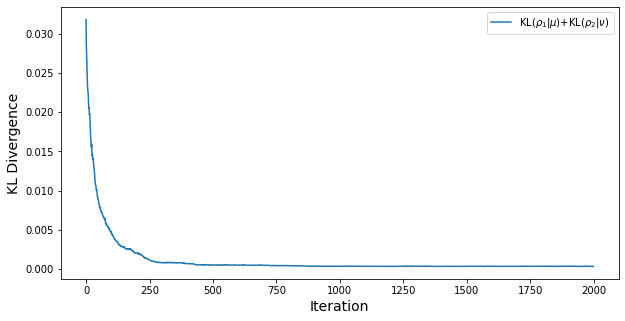

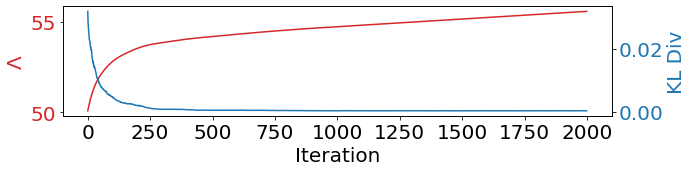

In [ ]:
# plot Lambda
plt.figure(figsize=(10,5))
plt.plot(rho_first_results[3],label=r'KL$(\rho_1|\mu)$+KL$(\rho_2|\nu)$')
plt.legend()
plt.ylabel('$\Lambda$', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.show()

# plot KL divergences
plt.figure(figsize=(10,5))
plt.plot((rho_first_results[2]-rho_first_results[4])/rho_first_results[3],label=r'KL$(\rho_1|\mu)$+KL$(\rho_2|\nu)$')
plt.legend()
plt.ylabel('KL Divergence', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.show()

# put both on same plot with different y axes
fig, ax1 = plt.subplots(figsize=(10,2.5))

color = 'tab:red'
ax1.set_xlabel('Iteration', fontsize=20)
ax1.set_ylabel('$\Lambda$', color=color, fontsize=20)
ax1.plot(rho_first_results[3], color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('KL Div', color=color,fontsize=20)  # we already handled the x-label with ax1
ax2.plot((rho_first_results[2]-rho_first_results[4])/rho_first_results[3],color=color)
ax2.tick_params(axis='y', labelcolor=color,labelsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("KL_divergence_lambda.png",bbox_inches='tight')
plt.show()


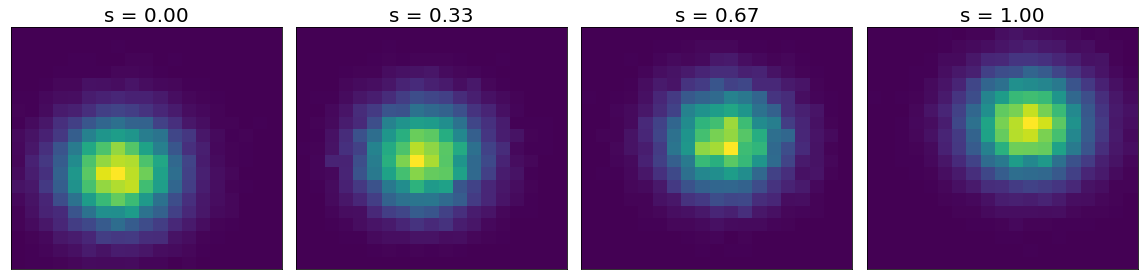

In [ ]:
# plot transport map
Nx = 19
n_transport = 4
s = np.linspace(0, 1, n_transport) # this is a transport interpolation

plt.figure(figsize=(4*n_transport, 4))
for i in range(n_transport):

    
    plt.subplot(1, n_transport,i+1)
    mixed_dist = s[i]*rho_first_results[1] + (1-s[i])*rho_first_results[0]
    plt.hist2d(mixed_dist[:, 0], mixed_dist[:, 1], bins=[np.linspace(0, 1, Nx+1)]*dmu, density=True)
    plt.title('s = %.2f' % s[i], fontsize=20)
    plt.xticks([])
    plt.yticks([])


plt.tight_layout()
plt.savefig('transport_map_approximation_Gaussian.png')
plt.show()




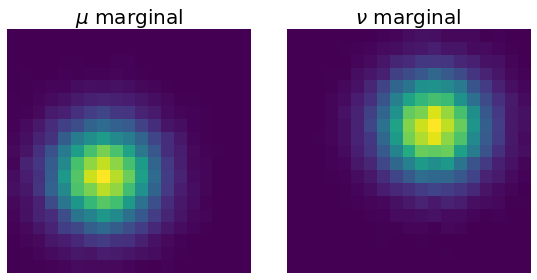

In [16]:
# plot target distributions mu and nu
mu_marginal = np.histogramdd(mu_samples, bins=[np.linspace(0, 1, Nx+1)]*dmu,density=True)[0]
nu_marginal = np.histogramdd(nu_samples, bins=[np.linspace(0, 1, Nx+1)]*dnu,density=True)[0]
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(mu_marginal.T,  interpolation='nearest',origin='lower')
plt.title(r'$\mu$ marginal', fontsize=20)
plt.axis('off')
plt.subplot(122)
plt.imshow(nu_marginal.T, interpolation='nearest',origin='lower')
plt.title(r'$\nu$ marginal', fontsize=20)
plt.axis('off')
plt.subplots_adjust(hspace=0.5, wspace=0)
plt.tight_layout()
plt.savefig('target_distributions.png')
plt.show()

In [17]:
# compute L2 norm between target and approximated marginals

X_final = rho_first_results[0]
Y_final = rho_first_results[1]
X_final_marginal = np.histogramdd(X_final, bins=[np.linspace(0, 1, Nx+1)]*dmu,density=True)[0]
Y_final_marginal = np.histogramdd(Y_final, bins=[np.linspace(0, 1, Nx+1)]*dnu,density=True)[0]
L2error_X = np.linalg.norm(X_final_marginal-mu_marginal)/Nx**2
L2error_Y = np.linalg.norm(Y_final_marginal-nu_marginal)/Nx**2
print("L2 error X: ",L2error_X)
print("L2 error Y: ",L2error_Y)
print("total $L^2$ error for rho first: ",L2error_X+L2error_Y)
kl_rho_first = entropy_rho_first(X_final_marginal,Y_final_marginal,mu_marginal,nu_marginal)/Nx**2
kl_mu_first = entropy_mu_first(X_final_marginal,Y_final_marginal,mu_marginal,nu_marginal)/Nx**2
print("KL error, rho first",kl_rho_first)
print("KL error, mu first",kl_mu_first)
print("total KL error for rho first: ",kl_rho_first+kl_mu_first)
print('\n')



L2 error X:  0.004554942370656294
L2 error Y:  0.003491597055789801
total $L^2$ error for rho first:  0.008046539426446096
KL error, rho first 0.036299274153827096
KL error, mu first 0.059632318206130554
total KL error for rho first:  0.09593159235995766


